# Lab 9a: PCA for Face Recognition
    
Following the demo for this unit, we will explore further the use of PCA for feature dimension reduction for classification. We will use a 2-layer neural net on the PCA coefficients. We will practice optimizing the classificaiton parameters (the number of PCA components and the number of hidden nodes in the NN classifier). We will furthermore compare this approach with using convolutional neural net on raw images.

Through the lab, you will learn to:

* Perform PCA on the a face dataset to find the PC components
* Evaluate the effect of using different nubmer of principle components for data representation and classification.
* Optimize the number of PC coefficients and classifier parameters together to maximize classification accuracy.
* Understand the impact of training data size on the feature and classification method selection.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Import the flw_people dataset. 
# Select only those people with at least 100 instances 
# Reduce the face image size by 0.4

# TO DO
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

In [3]:
# Save the face images in a datamatrix X and the labels and corresponding names in a datamatrix y and target_names
# Furthermore, determine the number of samples and the image size 
# Determine the number of different faces (number of classes)

# TO DO
# Get images
n_samples, h, w = lfw_people.images.shape
npix = h*w

# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]

# Labels of images 
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Image size     = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix))
print("Number faces   = {0:d}".format(n_samples))
print("Number classes = {0:d}".format(n_classes))

Image size     = 50 x 37 = 1850 pixels
Number faces   = 1140
Number classes = 5


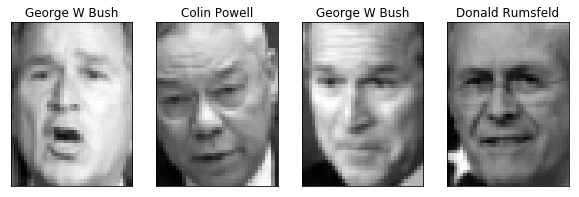

In [4]:
# Plot some sample images to make sure your data load is correct
def plt_face(x):
    h = 50
    w = 37
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    
I = np.random.permutation(n_samples)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(X[ind])
    plt.title(target_names[y[ind]])

In [5]:
# Split the data into a training set and test set with 50% data for training. 
# Use "stratify" option to make sure the training data and test data have same 
# proportion of images from different faces
# print the number of samples in the training data

# TO DO
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=43)

In [6]:
# Perfom PCA on the training data to derive the principle components (PCs) and the PCA coefficients 
# You can directly use the PCA class in PCA package or use SVD.
# Remember that you need to remove the mean from the data first
# Also you should rescale the PCs so that the PCA coefficients all have unit variance
# Determine the total number of PCs
from sklearn.decomposition import PCA
# TO DO 
npc = 100
n_samples, _ = X_train.shape
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Xts_mean = np.mean(X_test,0)
Xts = X_test - Xts_mean[None,:]
# Utr,Str,Vtr = np.linalg.svd(Xtr, full_matrices=False)

pca = PCA(n_components=npc, svd_solver='randomized', whiten=True).fit(Xtr)

First let us construct a 2-layer neural net classifier that uses npc= 100 PCA coefficients to classify the faces.  Set up your training and testing data to contain npc PCA coefficients using the previously determined principle components. You should directly use matrix multiplication (i.e. projecting original data to the first 100 principle components you found previously) to find the coefficients rather then using the pca.transform( ) method.


In [7]:
# TO DO
Xtr_pca = pca.transform(Xtr)
Xts_pca = pca.transform(Xts)

Now set up and compile a NN model with number of hidden nodes nnode=100 and a output layer, and then fit the model to the training data. Use 'relu' for the activation for the hidden layer and use 'softmax' for the output layer. Using `sparse_categorical_crossentropy` for the loss. Use `accuracy` as the metrics. You can choose to do a small number of epochs (=10) with batch size =100.  Determine the accuracy on the validation set.

In [8]:
# TO DO
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

nnode = 100
lr = 1e-3
nepochs = 1000
batch_size = 200

K.clear_session()
model = Sequential()
model.add(Dense(nnode, activation = 'relu', input_shape=Xtr_pca.shape[1:]))
model.add(Dense(n_classes, activation = 'softmax'))
opt = optimizers.Adam(lr=lr)
hist = model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
print(model.summary()) 
hist = model.fit(Xtr_pca, y_train, batch_size=batch_size,
              epochs=nepochs, validation_data=(Xts_pca, y_test),
              shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 10,605
Trainable params: 10,605
Non-trainable params: 0
_________________________________________________________________
None
Train on 570 samples, validate on 570 samples
Epoch 1/1000
570/570 [==============================] - 0s 348us/sample - loss: 1.8682 - acc: 0.2211 - val_loss: 1.7133 - val_acc: 0.2649
Epoch 2/1000
570/570 [==============================] - 0s 19us/sample - loss: 1.6952 - acc: 0.2754 - val_loss: 1.5956 - val_acc: 0.3140
Epoch 3/1000
570/570 [==============================] - 0s 21us/sample - loss: 1.5463 - acc: 0.3333 - val_loss: 1.4939 - val_acc: 0.3667

570/570 [==============================] - 0s 19us/sample - loss: 0.0888 - acc: 1.0000 - val_loss: 0.5385 - val_acc: 0.8316
Epoch 54/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0853 - acc: 1.0000 - val_loss: 0.5363 - val_acc: 0.8333
Epoch 55/1000
570/570 [==============================] - 0s 19us/sample - loss: 0.0821 - acc: 1.0000 - val_loss: 0.5342 - val_acc: 0.8351
Epoch 56/1000
570/570 [==============================] - 0s 22us/sample - loss: 0.0791 - acc: 1.0000 - val_loss: 0.5321 - val_acc: 0.8368
Epoch 57/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0762 - acc: 1.0000 - val_loss: 0.5302 - val_acc: 0.8368
Epoch 58/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0734 - acc: 1.0000 - val_loss: 0.5284 - val_acc: 0.8368
Epoch 59/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0709 - acc: 1.0000 - val_loss: 0.5267 - val_acc: 0.8368
Epoch 60/1000
570/570 [=========================

570/570 [==============================] - 0s 19us/sample - loss: 0.0186 - acc: 1.0000 - val_loss: 0.5011 - val_acc: 0.8544
Epoch 113/1000
570/570 [==============================] - 0s 19us/sample - loss: 0.0182 - acc: 1.0000 - val_loss: 0.5011 - val_acc: 0.8561
Epoch 114/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0179 - acc: 1.0000 - val_loss: 0.5010 - val_acc: 0.8544
Epoch 115/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0176 - acc: 1.0000 - val_loss: 0.5011 - val_acc: 0.8544
Epoch 116/1000
570/570 [==============================] - 0s 23us/sample - loss: 0.0173 - acc: 1.0000 - val_loss: 0.5012 - val_acc: 0.8544
Epoch 117/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0170 - acc: 1.0000 - val_loss: 0.5012 - val_acc: 0.8544
Epoch 118/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0167 - acc: 1.0000 - val_loss: 0.5012 - val_acc: 0.8544
Epoch 119/1000
570/570 [==================

570/570 [==============================] - 0s 21us/sample - loss: 0.0080 - acc: 1.0000 - val_loss: 0.5088 - val_acc: 0.8561
Epoch 172/1000
570/570 [==============================] - 0s 18us/sample - loss: 0.0079 - acc: 1.0000 - val_loss: 0.5090 - val_acc: 0.8544
Epoch 173/1000
570/570 [==============================] - 0s 22us/sample - loss: 0.0078 - acc: 1.0000 - val_loss: 0.5092 - val_acc: 0.8561
Epoch 174/1000
570/570 [==============================] - 0s 22us/sample - loss: 0.0077 - acc: 1.0000 - val_loss: 0.5094 - val_acc: 0.8561
Epoch 175/1000
570/570 [==============================] - 0s 19us/sample - loss: 0.0076 - acc: 1.0000 - val_loss: 0.5095 - val_acc: 0.8561
Epoch 176/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0075 - acc: 1.0000 - val_loss: 0.5097 - val_acc: 0.8561
Epoch 177/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0074 - acc: 1.0000 - val_loss: 0.5099 - val_acc: 0.8561
Epoch 178/1000
570/570 [==================

570/570 [==============================] - 0s 21us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 0.5200 - val_acc: 0.8596
Epoch 231/1000
570/570 [==============================] - 0s 18us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 0.5202 - val_acc: 0.8596
Epoch 232/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 0.5205 - val_acc: 0.8596
Epoch 233/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0043 - acc: 1.0000 - val_loss: 0.5207 - val_acc: 0.8596
Epoch 234/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0043 - acc: 1.0000 - val_loss: 0.5209 - val_acc: 0.8596
Epoch 235/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0043 - acc: 1.0000 - val_loss: 0.5211 - val_acc: 0.8596
Epoch 236/1000
570/570 [==============================] - 0s 19us/sample - loss: 0.0042 - acc: 1.0000 - val_loss: 0.5213 - val_acc: 0.8596
Epoch 237/1000
570/570 [==================

570/570 [==============================] - 0s 19us/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 0.5313 - val_acc: 0.8632
Epoch 290/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 0.5315 - val_acc: 0.8632
Epoch 291/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 0.5317 - val_acc: 0.8632
Epoch 292/1000
570/570 [==============================] - 0s 19us/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 0.5319 - val_acc: 0.8632
Epoch 293/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 0.5320 - val_acc: 0.8632
Epoch 294/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0027 - acc: 1.0000 - val_loss: 0.5322 - val_acc: 0.8632
Epoch 295/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0027 - acc: 1.0000 - val_loss: 0.5324 - val_acc: 0.8632
Epoch 296/1000
570/570 [==================

570/570 [==============================] - 0s 21us/sample - loss: 0.0020 - acc: 1.0000 - val_loss: 0.5420 - val_acc: 0.8596
Epoch 349/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5422 - val_acc: 0.8596
Epoch 350/1000
570/570 [==============================] - 0s 18us/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5423 - val_acc: 0.8596
Epoch 351/1000
570/570 [==============================] - 0s 23us/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5425 - val_acc: 0.8596
Epoch 352/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5427 - val_acc: 0.8596
Epoch 353/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5428 - val_acc: 0.8596
Epoch 354/1000
570/570 [==============================] - 0s 22us/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5430 - val_acc: 0.8596
Epoch 355/1000
570/570 [==================

570/570 [==============================] - 0s 22us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5520 - val_acc: 0.8614
Epoch 408/1000
570/570 [==============================] - 0s 19us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5521 - val_acc: 0.8614
Epoch 409/1000
570/570 [==============================] - 0s 22us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5523 - val_acc: 0.8614
Epoch 410/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5525 - val_acc: 0.8614
Epoch 411/1000
570/570 [==============================] - 0s 19us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5526 - val_acc: 0.8614
Epoch 412/1000
570/570 [==============================] - 0s 21us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5528 - val_acc: 0.8614
Epoch 413/1000
570/570 [==============================] - 0s 22us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5529 - val_acc: 0.8614
Epoch 414/1000
570/570 [==================

570/570 [==============================] - 0s 20us/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5613 - val_acc: 0.8614
Epoch 467/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5614 - val_acc: 0.8614
Epoch 468/1000
570/570 [==============================] - 0s 18us/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5616 - val_acc: 0.8614
Epoch 469/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5617 - val_acc: 0.8614
Epoch 470/1000
570/570 [==============================] - 0s 22us/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5619 - val_acc: 0.8614
Epoch 471/1000
570/570 [==============================] - 0s 18us/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5620 - val_acc: 0.8614
Epoch 472/1000
570/570 [==============================] - 0s 20us/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5622 - val_acc: 0.8614
Epoch 473/1000
570/570 [==================

Epoch 524/1000
570/570 [==============================] - 0s 19us/sample - loss: 8.5329e-04 - acc: 1.0000 - val_loss: 0.5698 - val_acc: 0.8632
Epoch 525/1000
570/570 [==============================] - 0s 19us/sample - loss: 8.4992e-04 - acc: 1.0000 - val_loss: 0.5700 - val_acc: 0.8632
Epoch 526/1000
570/570 [==============================] - 0s 24us/sample - loss: 8.4664e-04 - acc: 1.0000 - val_loss: 0.5701 - val_acc: 0.8632
Epoch 527/1000
570/570 [==============================] - 0s 20us/sample - loss: 8.4329e-04 - acc: 1.0000 - val_loss: 0.5703 - val_acc: 0.8649
Epoch 528/1000
570/570 [==============================] - 0s 22us/sample - loss: 8.3992e-04 - acc: 1.0000 - val_loss: 0.5704 - val_acc: 0.8649
Epoch 529/1000
570/570 [==============================] - 0s 22us/sample - loss: 8.3663e-04 - acc: 1.0000 - val_loss: 0.5705 - val_acc: 0.8649
Epoch 530/1000
570/570 [==============================] - 0s 20us/sample - loss: 8.3333e-04 - acc: 1.0000 - val_loss: 0.5707 - val_acc: 0.8649

570/570 [==============================] - 0s 21us/sample - loss: 6.8727e-04 - acc: 1.0000 - val_loss: 0.5778 - val_acc: 0.8649
Epoch 582/1000
570/570 [==============================] - 0s 21us/sample - loss: 6.8475e-04 - acc: 1.0000 - val_loss: 0.5780 - val_acc: 0.8649
Epoch 583/1000
570/570 [==============================] - 0s 20us/sample - loss: 6.8227e-04 - acc: 1.0000 - val_loss: 0.5781 - val_acc: 0.8649
Epoch 584/1000
570/570 [==============================] - 0s 22us/sample - loss: 6.7985e-04 - acc: 1.0000 - val_loss: 0.5782 - val_acc: 0.8649
Epoch 585/1000
570/570 [==============================] - 0s 20us/sample - loss: 6.7734e-04 - acc: 1.0000 - val_loss: 0.5784 - val_acc: 0.8649
Epoch 586/1000
570/570 [==============================] - 0s 19us/sample - loss: 6.7490e-04 - acc: 1.0000 - val_loss: 0.5785 - val_acc: 0.8649
Epoch 587/1000
570/570 [==============================] - 0s 20us/sample - loss: 6.7248e-04 - acc: 1.0000 - val_loss: 0.5786 - val_acc: 0.8649
Epoch 588/1000

570/570 [==============================] - 0s 19us/sample - loss: 5.6297e-04 - acc: 1.0000 - val_loss: 0.5853 - val_acc: 0.8667
Epoch 639/1000
570/570 [==============================] - 0s 20us/sample - loss: 5.6115e-04 - acc: 1.0000 - val_loss: 0.5855 - val_acc: 0.8667
Epoch 640/1000
570/570 [==============================] - 0s 21us/sample - loss: 5.5922e-04 - acc: 1.0000 - val_loss: 0.5856 - val_acc: 0.8667
Epoch 641/1000
570/570 [==============================] - 0s 23us/sample - loss: 5.5733e-04 - acc: 1.0000 - val_loss: 0.5857 - val_acc: 0.8667
Epoch 642/1000
570/570 [==============================] - 0s 22us/sample - loss: 5.5544e-04 - acc: 1.0000 - val_loss: 0.5859 - val_acc: 0.8667
Epoch 643/1000
570/570 [==============================] - 0s 20us/sample - loss: 5.5362e-04 - acc: 1.0000 - val_loss: 0.5860 - val_acc: 0.8667
Epoch 644/1000
570/570 [==============================] - 0s 19us/sample - loss: 5.5174e-04 - acc: 1.0000 - val_loss: 0.5861 - val_acc: 0.8667
Epoch 645/1000

570/570 [==============================] - 0s 21us/sample - loss: 4.6752e-04 - acc: 1.0000 - val_loss: 0.5925 - val_acc: 0.8667
Epoch 696/1000
570/570 [==============================] - 0s 20us/sample - loss: 4.6600e-04 - acc: 1.0000 - val_loss: 0.5926 - val_acc: 0.8667
Epoch 697/1000
570/570 [==============================] - 0s 19us/sample - loss: 4.6457e-04 - acc: 1.0000 - val_loss: 0.5927 - val_acc: 0.8684
Epoch 698/1000
570/570 [==============================] - 0s 22us/sample - loss: 4.6310e-04 - acc: 1.0000 - val_loss: 0.5929 - val_acc: 0.8684
Epoch 699/1000
570/570 [==============================] - 0s 21us/sample - loss: 4.6165e-04 - acc: 1.0000 - val_loss: 0.5930 - val_acc: 0.8684
Epoch 700/1000
570/570 [==============================] - 0s 23us/sample - loss: 4.6022e-04 - acc: 1.0000 - val_loss: 0.5931 - val_acc: 0.8684
Epoch 701/1000
570/570 [==============================] - 0s 21us/sample - loss: 4.5873e-04 - acc: 1.0000 - val_loss: 0.5932 - val_acc: 0.8684
Epoch 702/1000

570/570 [==============================] - 0s 20us/sample - loss: 3.9254e-04 - acc: 1.0000 - val_loss: 0.5986 - val_acc: 0.8702
Epoch 753/1000
570/570 [==============================] - 0s 21us/sample - loss: 3.9140e-04 - acc: 1.0000 - val_loss: 0.5987 - val_acc: 0.8702
Epoch 754/1000
570/570 [==============================] - 0s 18us/sample - loss: 3.9022e-04 - acc: 1.0000 - val_loss: 0.5988 - val_acc: 0.8702
Epoch 755/1000
570/570 [==============================] - 0s 22us/sample - loss: 3.8909e-04 - acc: 1.0000 - val_loss: 0.5989 - val_acc: 0.8702
Epoch 756/1000
570/570 [==============================] - 0s 21us/sample - loss: 3.8791e-04 - acc: 1.0000 - val_loss: 0.5990 - val_acc: 0.8702
Epoch 757/1000
570/570 [==============================] - 0s 21us/sample - loss: 3.8676e-04 - acc: 1.0000 - val_loss: 0.5991 - val_acc: 0.8702
Epoch 758/1000
570/570 [==============================] - 0s 22us/sample - loss: 3.8562e-04 - acc: 1.0000 - val_loss: 0.5992 - val_acc: 0.8702
Epoch 759/1000

570/570 [==============================] - 0s 20us/sample - loss: 3.3274e-04 - acc: 1.0000 - val_loss: 0.6043 - val_acc: 0.8667
Epoch 810/1000
570/570 [==============================] - 0s 21us/sample - loss: 3.3179e-04 - acc: 1.0000 - val_loss: 0.6044 - val_acc: 0.8667
Epoch 811/1000
570/570 [==============================] - 0s 19us/sample - loss: 3.3086e-04 - acc: 1.0000 - val_loss: 0.6045 - val_acc: 0.8667
Epoch 812/1000
570/570 [==============================] - 0s 23us/sample - loss: 3.2990e-04 - acc: 1.0000 - val_loss: 0.6046 - val_acc: 0.8667
Epoch 813/1000
570/570 [==============================] - 0s 20us/sample - loss: 3.2898e-04 - acc: 1.0000 - val_loss: 0.6047 - val_acc: 0.8667
Epoch 814/1000
570/570 [==============================] - 0s 20us/sample - loss: 3.2806e-04 - acc: 1.0000 - val_loss: 0.6048 - val_acc: 0.8667
Epoch 815/1000
570/570 [==============================] - 0s 19us/sample - loss: 3.2714e-04 - acc: 1.0000 - val_loss: 0.6048 - val_acc: 0.8667
Epoch 816/1000

570/570 [==============================] - 0s 20us/sample - loss: 2.8430e-04 - acc: 1.0000 - val_loss: 0.6098 - val_acc: 0.8667
Epoch 867/1000
570/570 [==============================] - 0s 18us/sample - loss: 2.8353e-04 - acc: 1.0000 - val_loss: 0.6099 - val_acc: 0.8667
Epoch 868/1000
570/570 [==============================] - 0s 19us/sample - loss: 2.8277e-04 - acc: 1.0000 - val_loss: 0.6100 - val_acc: 0.8667
Epoch 869/1000
570/570 [==============================] - 0s 22us/sample - loss: 2.8202e-04 - acc: 1.0000 - val_loss: 0.6101 - val_acc: 0.8667
Epoch 870/1000
570/570 [==============================] - 0s 20us/sample - loss: 2.8126e-04 - acc: 1.0000 - val_loss: 0.6102 - val_acc: 0.8667
Epoch 871/1000
570/570 [==============================] - 0s 21us/sample - loss: 2.8049e-04 - acc: 1.0000 - val_loss: 0.6103 - val_acc: 0.8684
Epoch 872/1000
570/570 [==============================] - 0s 21us/sample - loss: 2.7976e-04 - acc: 1.0000 - val_loss: 0.6104 - val_acc: 0.8684
Epoch 873/1000

570/570 [==============================] - 0s 21us/sample - loss: 2.4462e-04 - acc: 1.0000 - val_loss: 0.6151 - val_acc: 0.8684
Epoch 924/1000
570/570 [==============================] - 0s 21us/sample - loss: 2.4400e-04 - acc: 1.0000 - val_loss: 0.6152 - val_acc: 0.8684
Epoch 925/1000
570/570 [==============================] - 0s 19us/sample - loss: 2.4336e-04 - acc: 1.0000 - val_loss: 0.6153 - val_acc: 0.8684
Epoch 926/1000
570/570 [==============================] - 0s 23us/sample - loss: 2.4273e-04 - acc: 1.0000 - val_loss: 0.6154 - val_acc: 0.8684
Epoch 927/1000
570/570 [==============================] - 0s 21us/sample - loss: 2.4211e-04 - acc: 1.0000 - val_loss: 0.6155 - val_acc: 0.8684
Epoch 928/1000
570/570 [==============================] - 0s 19us/sample - loss: 2.4149e-04 - acc: 1.0000 - val_loss: 0.6156 - val_acc: 0.8684
Epoch 929/1000
570/570 [==============================] - 0s 20us/sample - loss: 2.4088e-04 - acc: 1.0000 - val_loss: 0.6157 - val_acc: 0.8684
Epoch 930/1000

570/570 [==============================] - 0s 18us/sample - loss: 2.1177e-04 - acc: 1.0000 - val_loss: 0.6203 - val_acc: 0.8684
Epoch 981/1000
570/570 [==============================] - 0s 20us/sample - loss: 2.1125e-04 - acc: 1.0000 - val_loss: 0.6204 - val_acc: 0.8684
Epoch 982/1000
570/570 [==============================] - 0s 21us/sample - loss: 2.1071e-04 - acc: 1.0000 - val_loss: 0.6205 - val_acc: 0.8684
Epoch 983/1000
570/570 [==============================] - 0s 23us/sample - loss: 2.1019e-04 - acc: 1.0000 - val_loss: 0.6206 - val_acc: 0.8684
Epoch 984/1000
570/570 [==============================] - 0s 21us/sample - loss: 2.0969e-04 - acc: 1.0000 - val_loss: 0.6207 - val_acc: 0.8684
Epoch 985/1000
570/570 [==============================] - 0s 20us/sample - loss: 2.0916e-04 - acc: 1.0000 - val_loss: 0.6208 - val_acc: 0.8684
Epoch 986/1000
570/570 [==============================] - 0s 21us/sample - loss: 2.0864e-04 - acc: 1.0000 - val_loss: 0.6209 - val_acc: 0.8684
Epoch 987/1000

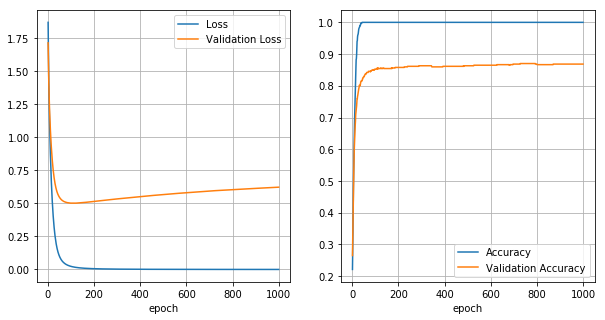

In [9]:
epochsn=np.arange(1, nepochs+1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochsn, hist.history['loss'], label='Loss')
plt.plot(epochsn, hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.grid()
plt.subplot(1,2,2)
plt.plot(epochsn, hist.history['acc'], label='Accuracy')
plt.plot(epochsn, hist.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.xlabel('epoch')
plt.grid()
plt.show()

Now try to identify the best number of PCs and the best number of hidden nodes in the NN classifer that can achieve the highest validation accuracy. 
You can set the range of PCs and nubmer of hidden nodes as below.

nnodes = [50,100,150,200, 250],
npcs = [50,100,150,200]


In [10]:
# Set up an array to store accuracy for different nnode and npcs
# TO DO
nnodes = [50,100,150,200,250]
npcs = [50,100,150,200]
hist_value = np.zeros((4,len(nnodes),len(npcs),nepochs))


In [11]:
# Loop through the combinations to find the accuracy for each combination
# For each possible combination of `nnode` and `npc`, set up and fit the model 
# using features containing only coefficents corresponding to npc coefficients.

# TO DO 
for i, node in enumerate(nnodes):
    for j, pcs in enumerate(npcs):
        # PCA
        pca = PCA(n_components=pcs, svd_solver='randomized', whiten=True).fit(Xtr)
        Xtr_pca = pca.transform(Xtr)
        Xts_pca = pca.transform(Xts)
        # NN
        K.clear_session()
        model = Sequential()
        model.add(Dense(node, activation = 'relu', input_shape=Xtr_pca.shape[1:]))
        model.add(Dense(n_classes, activation = 'softmax'))
        opt = optimizers.Adam(lr=lr)
        hist = model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
        print(model.summary()) 
        hist = model.fit(Xtr_pca, y_train, batch_size=batch_size,
              epochs=nepochs, validation_data=(Xts_pca, y_test),
              shuffle=False, verbose=0)
        hist_value[0,i,j,:] = hist.history['loss']
        hist_value[1,i,j,:] = hist.history['val_loss']
        hist_value[2,i,j,:] = hist.history['acc']
        hist_value[3,i,j,:] = hist.history['val_acc']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 2,805
Trainable params: 2,805
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 5,305
Trainable params: 5,305
Non-trainable params: 0
_________________________________________________________________
None
______________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               30200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 31,205
Trainable params: 31,205
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 41,205
Trainable params: 41,205
Non-trainable params: 0
_________________________________________________________________
None
__________________________________________________________

In [12]:
# Determine the npc and nnode that provides the highest validation accuracy 
# TO DO 
tmp = np.mean(hist_value[3,:,:,-10:],axis=2)
tmp = np.argmax(tmp)
n1 = tmp//len(npcs)
n2 = tmp%len(npcs)
opt_node = nnodes[n1]
opt_npc = npcs[n2]
print('Optimal nnode = ', opt_node)
print('Optimal npc = ', opt_npc)


Optimal nnode =  150
Optimal npc =  100


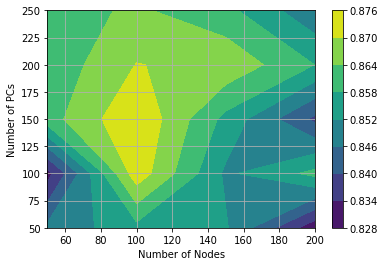

In [13]:
# Produce a contour plot of the accuracy using different nnode and npc combincations
# TO DO
# epochsn=np.arange(1, nepochs+1)
# plt.figure(figsize=(10,10))
# for i in range(len(nnodes)):
#     for j in range(len(npcs)):
#         plt.subplot(2,2,1)
#         plt.plot(epochsn, hist_value[0,i,j,:], label='Num of Nodes = '+ np.str(i) + ', Num of PC = ' + np.str(j))
#         plt.subplot(2,2,2)
#         plt.plot(epochsn, hist_value[1,i,j,:], label='Num of Nodes = '+ np.str(i) + ', Num of PC = ' + np.str(j))
#         plt.subplot(2,2,3)
#         plt.plot(epochsn, hist_value[2,i,j,:], label='Num of Nodes = '+ np.str(i) + ', Num of PC = ' + np.str(j))
#         plt.subplot(2,2,4)
#         plt.plot(epochsn, hist_value[3,i,j,:], label='Num of Nodes = '+ np.str(i) + ', Num of PC = ' + np.str(j))
# plt.subplot(2,2,1)
# plt.title('Loss')
# plt.xlabel('epoch')
# # plt.legend()
# plt.grid()
# plt.subplot(2,2,2)
# plt.title('Validation Loss')
# plt.xlabel('epoch')
# # plt.legend()
# plt.grid()
# plt.subplot(2,2,3)
# plt.title('Accuracy')
# plt.xlabel('epoch')
# # plt.legend()
# plt.grid()
# plt.subplot(2,2,4)
# plt.title('Validation Accuracy')
# plt.xlabel('epoch')
# # plt.legend()
# plt.grid()
# plt.show()
# plt.contourf ...
tmp = np.mean(hist_value[3,:,:,-10:],axis=2)
NN, NP = np.meshgrid(npcs, nnodes)
plt.figure()
# tmp = np.reshape(hist_value[3,:,:,:],(4*5,nepochs))
plt.contourf(NN, NP, tmp)
plt.xlabel('Number of Nodes')
plt.ylabel('Number of PCs')
plt.grid()
plt.colorbar()
plt.show()

## Now let us compare the PCA+NN with applying a CNN on the raw image data only. 

Note that you should scale your image data to between 0 and 1. And you should reshape your training and testing data according to image width and height


In [14]:
# Data preparation for input to CNN
# TO DO
Xtr = np.reshape(X_train.astype('float32') / 255., (X_train.shape[0],h,w,1))
Xts = np.reshape(X_test.astype('float32') / 255., (X_test.shape[0],h,w,1))

In [15]:
# Set up a CNN model
# You can use 2 conv2D layer, each with kernel size of 5x5, each followed by a pooling layer with strides of 2
# For this part, let both conv2D layer generate 16 channels. 
# The Conv layer should be followed by a flatten layer and two dense layers. 
# The first dense layer should produce 200 outputs. 
# The last dense layer is the output layer with n_classes output using 'softmax' activation.
# Print model summary to verify it follows the desired structure and compile the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten

# TO DO 
def create_mod(input_shape, n_classes, hid_ch):
    model = Sequential()
    model.add(Conv2D(hid_ch, (5, 5), padding='valid', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hid_ch, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(200, activation = 'relu'))
    model.add(Dense(n_classes, activation = 'softmax'))
    
    return model

# NN
K.clear_session()
model = create_mod(Xtr.shape[1:], n_classes, 16)
model.summary()
opt = optimizers.Adam(lr=lr)
hist = model.compile(loss='sparse_categorical_crossentropy',
          optimizer=opt,
          metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 33, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 12, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 864)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               173000    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total para

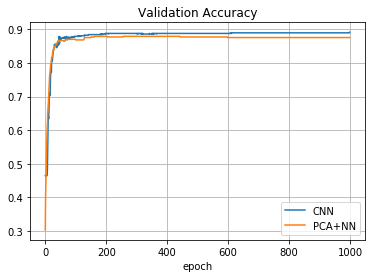

In [16]:
# Fit the model using batch size=100, epochs = 40
# Print the accuracy on the validation set

# TO DO 
batch_size = 100
# nepochs = 4
hist = model.fit(Xtr, y_train, batch_size=batch_size,
      epochs=nepochs, validation_data=(Xts, y_test),
      shuffle=False, verbose=0)

plt.figure()
plt.plot(np.arange(nepochs), hist.history['val_acc'], label='CNN')
plt.plot(np.arange(nepochs), hist_value[3,n1,n2,:], label='PCA+NN')
plt.xlabel('epoch')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

How do the result compared with the PCA+NN method? (If you did right, they should be similar, with PCA+NN being slightly better. If you used more training data (e.g. 75%) and you trained the CNN with more epochs, CNN method may get better). 

A: 

## Repeat the above using a small dataset

Instead of using 50% of the total data for training, let us assume you have only 10% of the total data for training. Repeat both the PCA+NN and the CNN method, to see which one gives you better results. 

Note that with only 10% data for training, the range of the npc has to be set to be below the total number of training samples. 

For the CNN model, because you have small number of training samples, you cannot train a network with a large number of parameters reliably. Instead of producing 16 channels for each of the two conv2D layers, configure the model to produce only 8 channels each. 

(114, 1850)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 2,805
Trainable params: 2,805
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 5,305
Trainable params: 5,305
Non-trainable params: 0
_________________________________________________________________
None
__________________________________________________

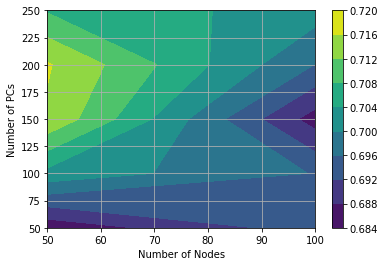

In [17]:
## TO DO
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, stratify=y, random_state=43)
print(X_train.shape)
# Perfom PCA
npc = 100
n_samples, _ = X_train.shape
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Xts_mean = np.mean(X_test,0)
Xts = X_test - Xts_mean[None,:]
pca = PCA(n_components=npc, svd_solver='randomized', whiten=True).fit(Xtr)
# TO DO
Xtr_pca = pca.transform(Xtr)
Xts_pca = pca.transform(Xts)
# Loop through the combinations to find the accuracy for each combination
nnodes = [50,100,150,200,250]
npcs = [50,100]
hist_value = np.zeros((4,len(nnodes),len(npcs),nepochs))
for i, node in enumerate(nnodes):
    for j, pcs in enumerate(npcs):
        # PCA
        pca = PCA(n_components=pcs, svd_solver='randomized', whiten=True).fit(Xtr)
        Xtr_pca = pca.transform(Xtr)
        Xts_pca = pca.transform(Xts)
        # NN
        K.clear_session()
        model = Sequential()
        model.add(Dense(node, activation = 'relu', input_shape=Xtr_pca.shape[1:]))
        model.add(Dense(n_classes, activation = 'softmax'))
        opt = optimizers.Adam(lr=lr)
        hist = model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
        print(model.summary()) 
        hist = model.fit(Xtr_pca, y_train, batch_size=batch_size,
              epochs=nepochs, validation_data=(Xts_pca, y_test),
              shuffle=False, verbose=0)
        hist_value[0,i,j,:] = hist.history['loss']
        hist_value[1,i,j,:] = hist.history['val_loss']
        hist_value[2,i,j,:] = hist.history['acc']
        hist_value[3,i,j,:] = hist.history['val_acc']
# Determine the npc and nnode that provides the highest validation accuracy 
tmp = np.mean(hist_value[3,:,:,-10:],axis=2)
tmp = np.argmax(tmp)
n1 = tmp//len(npcs)
n2 = tmp%len(npcs)
opt_node = nnodes[n1]
opt_npc = npcs[n2]
print('Optimal nnode = ', opt_node)
print('Optimal npc = ', opt_npc)
# plt.contourf ...
tmp = np.mean(hist_value[3,:,:,-10:],axis=2)
NN, NP = np.meshgrid(npcs, nnodes)
plt.figure()
# tmp = np.reshape(hist_value[3,:,:,:],(4*5,nepochs))
plt.contourf(NN, NP, tmp)
plt.xlabel('Number of Nodes')
plt.ylabel('Number of PCs')
plt.grid()
plt.colorbar()
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 33, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 12, 8)         1608      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 6, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 432)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               86600     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total para

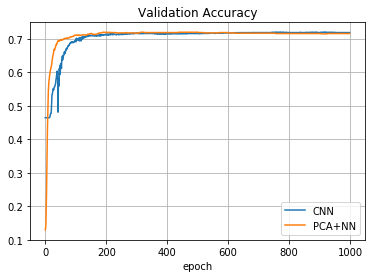

In [18]:
# Data preparation for input to CNN
Xtr = np.reshape(X_train.astype('float32') / 255., (X_train.shape[0],h,w,1))
Xts = np.reshape(X_test.astype('float32') / 255., (X_test.shape[0],h,w,1))
# NN
K.clear_session()
model = create_mod(Xtr.shape[1:], n_classes, 8)
model.summary()
opt = optimizers.Adam(lr=lr)
hist = model.compile(loss='sparse_categorical_crossentropy',
          optimizer=opt,
          metrics=['accuracy'])
# Fit the model using batch size=100, epochs = 40
# Print the accuracy on the validation set

# TO DO 
batch_size = 100
# nepochs = 4
hist = model.fit(Xtr, y_train, batch_size=batch_size,
      epochs=nepochs, validation_data=(Xts, y_test),
      shuffle=False, verbose=0)

plt.figure()
plt.plot(np.arange(nepochs), hist.history['val_acc'], label='CNN')
plt.plot(np.arange(nepochs), hist_value[3,n1,n2,:], label='PCA+NN')
plt.xlabel('epoch')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

Q: How does CNN compare with PCA+NN with the small training set? Why?

A: